In [ ]:
import requests
import json
from pymongo import MongoClient
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.optimize import curve_fit, least_squares
from celluloid import Camera

## Request for data
from https://github.com/DataScienceResearchPeru/covid-19_latinoamerica

In [ ]:
url = "https://covid19latam.herokuapp.com/data"
payload = {}
headers = {'accept': 'application/json'}

response = requests.request("GET", url, headers=headers, data = payload)

data = json.loads(response.text.encode('utf8'))

## Storage
Sending everything to a MongoDB Atlas collection, for faster querying.

In [ ]:
# Credentials
user = 'username'
password = 'password'
atlas_url = r"mongodb+srv://{}:{}@cluster0-t38ya.mongodb.net/test".format(username,password)

In [ ]:
# Connection to database
client = MongoClient(atlas_url)
database = client[ "covidlatam" ]
people_collection = database[ "evolution_over_time" ]

In [ ]:
# Inserting multiple documents
x = people_collection.insert_many(data)

# Updating from source

## Querying and transformation

In [ ]:
query = {'Country':'Peru'}

covid_peru = []
for p in people_collection.find(query):
    covid_peru.append(p)

covid_peru = pd.DataFrame(covid_peru)
covid_peru = covid_peru.set_index('_id')

In [ ]:
agg = {'Confirmed':['sum'],'Deaths':['sum'],'Recovered':['sum']}

covid_daily_pe = covid_peru.groupby('Date').agg(agg)

In [ ]:
# Some cleaning and transformations

covid_daily_pe = covid_daily_pe[covid_daily_pe[('Confirmed','sum')]>0]
covid_daily_pe = covid_daily_pe.reset_index()
covid_daily_pe['Date'] = pd.to_datetime(covid_daily_pe['Date'])

In [ ]:
covid_daily_pe['days_past_first'] = (covid_daily_pe['Date'] - covid_daily_pe['Date'].min()).dt.days

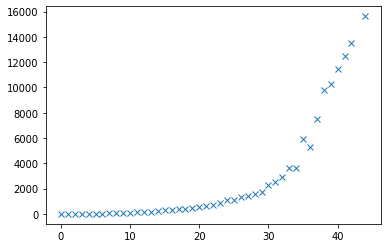

In [7]:
plt.plot(covid_daily_pe['days_past_first'],covid_daily_pe[('Confirmed','sum')],'x')

## Curve-fitting

In [ ]:
def logistic_curve(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0)))+b
    return y

In [ ]:
x_train = covid_daily_pe['days_past_first'].values
y_train = covid_daily_pe[('Confirmed','sum')].values
x_pred = np.arange(100)
y0 = [max(y_train), np.median(x_train),1,min(y_train)]

In [ ]:
popt, pcov = curve_fit(logistic_curve, x_train, y_train, y0, maxfev = 50000)
y_pred = logistic_curve(*[x_pred, *popt.tolist()])

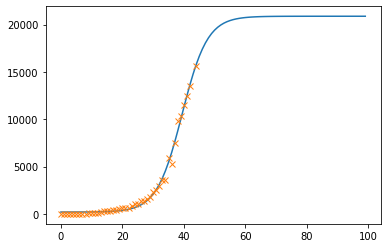

In [13]:
plt.plot(x_pred, y_pred)
plt.plot(x_train,y_train,'x')

## Animation

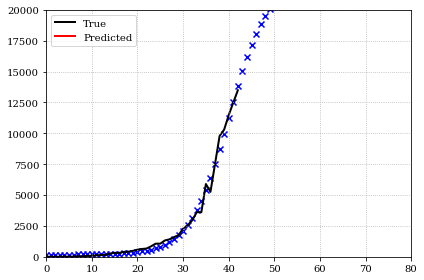

In [39]:
# plot the true curve and the observed points
plt.rcParams["font.family"] = 'serif'
plt.rcParams['font.size'] = 10
fig, ax = plt.subplots(figsize=(6,4))
scat = ax.scatter(x_pred,y_pred,marker='x',c='b')
plt.plot(x_train,y_train,c='k',lw='2',zorder=1,label='True')
plt.ylim(0,20000)
plt.xlim(0,80)
plt.grid(ls=':')
plt.tight_layout()
line, = ax.plot([], [], c='r',lw=2,zorder=2,label='Predicted')
line2, = ax.plot([], [], c='b',ls='--')
plt.legend(loc=2)
plt.legend(loc=2)

In [ ]:
def opt_param(t):
    x_train = covid_daily_pe['days_past_first'].values[:t]
    y_train = covid_daily_pe[('Confirmed','sum')].values[:t]
    x_pred = np.arange(100)
    y0 = [max(y_train), np.median(x_train),1,min(y_train)]
    
    popt, pcov = curve_fit(logistic_curve, x_train, y_train, y0, maxfev = 50000)
    y_pred = logistic_curve(*[x_pred, *popt.tolist()])
    
    return x_train, y_train, x_pred, y_pred, popt

In [ ]:
# Main loop
x_full = covid_daily_pe['days_past_first'].values
y_full = covid_daily_pe[('Confirmed','sum')].values
plt.rcParams["font.family"] = 'serif'
plt.rcParams['font.size'] = 10
fig = plt.figure()
camera = Camera(fig)
for j in range(10,120):

    i = j//2
    
    if (i < 35) and (j % 2 == 1): continue
    
    plt.ylim(0,30000)
    plt.xlim(0,60)
    
    x_train, y_train, x_pred, y_pred, popt = opt_param(i)
    plt.scatter(x_full,y_full,marker='x',c='k')
    scat = plt.scatter(x_train,y_train,marker='x',c='b')
    plt.plot(x_train,y_train,c='k',lw='2',zorder=1,label='True')
    line, = plt.plot(x_pred, y_pred, c='r',lw=2,zorder=2,label='Predicted')
    line2, = plt.plot(2*[max(x_train)], [0,250000], c='b',ls='--')
    plt.grid(ls=':')
    plt.tight_layout()
    plt.legend(['True','Predicted'])
    
    camera.snap()
    
animation = camera.animate()
animation.save('celluloid_minimal.gif', writer = 'imagemagick')

## Final result

<img src="celluloid_minimal.gif" width="500" align="center">